# Exporting ImageCollection to NetCDF

## Introduction

[XEE](https://github.com/google/Xee) is a XArray extension that allows reading data from Google Earth Engine (GEE). This extension is useful for extracting subsets of data hosted in GEE. In this tutorial, we will learn how to extract a large ImageCollection and save it as a local NetCDF file.

## Overview of the Task

We will take the [ERA5-Land Daily Aggregated](https://developers.google.com/earth-engine/datasets/catalog/ECMWF_ERA5_LAND_DAILY_AGGR) collection and export the subset for the chosen country as a CF-compatible format NetCDF file.

**Input Layers**:
* `ne_10m_admin_0_countries_ind.zip`: A shapefile of country boundaries

**Output**:
* `era5_subset.nc`: A NetCDF subset of the ERA5-Land Daily Aggregated data.

**Data Credit**:
- ERA5-Land monthly averaged data from 1981 to present. Copernicus Climate Change Service (C3S) Climate Data Store (CDS).
- Made with Natural Earth. Free vector and raster map data @ naturalearthdata.com.

## Setup and Data Download

The following blocks of code will install the required packages and download the datasets to your Colab environment.

In [1]:
%%capture
if 'google.colab' in str(get_ipython()):
    !pip install xee rioxarray netCDF4

In [ ]:
import ee
import geopandas as gpd
import numpy as np
import os
import rioxarray as rxr
import xarray as xr

In [ ]:
data_folder = 'data'
output_folder = 'output'

if not os.path.exists(data_folder):
    os.mkdir(data_folder)
if not os.path.exists(output_folder):
    os.mkdir(output_folder)

In [ ]:
def download(url):
    filename = os.path.join(data_folder, os.path.basename(url))
    if not os.path.exists(filename):
        from urllib.request import urlretrieve
        local, _ = urlretrieve(url, filename)
        print('Downloaded ' + local)

shapefile = 'ne_10m_admin_0_countries_ind.zip'

data_url = 'https://github.com/spatialthoughts/geopython-tutorials/releases/download/data/'
download('{}/{}'.format(data_url,shapefile))

Initialize EE with the [High-Volume EndPoint](https://developers.google.com/earth-engine/guides/processing_environments#high-volume_endpoint) recommended to be used with XEE.

> Replace the value of the `cloud_project` variable with your own project id that is linked with GEE.


In [ ]:
cloud_project = 'spatialthoughts'

try:
    ee.Initialize(project=cloud_project, opt_url='https://earthengine-highvolume.googleapis.com')
except:
    ee.Authenticate()
    ee.Initialize(project=cloud_project, opt_url='https://earthengine-highvolume.googleapis.com')

## Data Preparation

Use the Survey of India's International Boundary Shapefile to define the query extent.

In [ ]:
shapefile_path = os.path.join(data_folder, shapefile)
boundaries_gdf = gpd.read_file(shapefile_path)

Configure the time period and variables.

In [ ]:
start_year = 1984
end_year = 2023
variable = 'temperature_2m'

Open the subset using XEE.

In [ ]:
start_date = ee.Date.fromYMD(start_year, 1, 1)
end_date = ee.Date.fromYMD(end_year + 1, 1, 1)

era5 = ee.ImageCollection('ECMWF/ERA5_LAND/DAILY_AGGR')
filtered = era5 \
  .filter(ee.Filter.date(start_date, end_date)) \
  .filter(ee.Filter.bounds(geometry)) \
  .select(variable)

ds = xr.open_dataset(
    filtered,
    engine='ee',
    geometry=geometry,
    projection=filtered.first().select(0).projection(),
    fast_time_slicing=True,
    chunks={'index': 24},
)

In [ ]:
ds

<xarray.Dataset> Size: 5GB
Dimensions:         (time: 14610, lon: 293, lat: 303)
Coordinates:
  * time            (time) datetime64[ns] 117kB 1984-01-01 ... 2023-12-31
  * lon             (lon) float64 2kB 68.2 68.3 68.4 68.5 ... 97.2 97.3 97.4
  * lat             (lat) float64 2kB 37.04 36.94 36.84 ... 7.038 6.938 6.838
Data variables:
    temperature_2m  (time, lon, lat) float32 5GB dask.array<chunksize=(48, 293, 256), meta=np.ndarray>
Attributes:
    crs:      EPSG:4326

XEE queries the data for the bounding box of the provided geometry. So we still need to clip the pixels outside the geometry. Use `geemap` to convert the EE Asset to a GeoDataFrame so we can clip the XArray Dataset using `rioxarray`.

In [ ]:
gdf = geemap.ee_to_gdf(india)
clipped_ds = ds.rename({'lon': 'x', 'lat':'y'}).rio.clip(gdf.geometry.values)

Prepare the data for export. Currently XEE produces dataset with dimension ordering that is different than what is expected by many other Python/R packages. We transpose the data to fix this as [recommended by XEE developers](https://github.com/google/Xee/issues/171).

In [ ]:
export_ds = clipped_ds.transpose()

In [ ]:
export_ds

<xarray.Dataset> Size: 5GB
Dimensions:         (time: 14610, x: 292, y: 303)
Coordinates:
  * time            (time) datetime64[ns] 117kB 1984-01-01 ... 2023-12-31
  * x               (x) float64 2kB 68.2 68.3 68.4 68.5 ... 97.0 97.1 97.2 97.3
  * y               (y) float64 2kB 37.04 36.94 36.84 ... 7.038 6.938 6.838
    spatial_ref     int64 8B 0
Data variables:
    temperature_2m  (y, x, time) float32 5GB dask.array<chunksize=(256, 292, 48), meta=np.ndarray>
Attributes:
    crs:      EPSG:4326

## Exporting the Subset

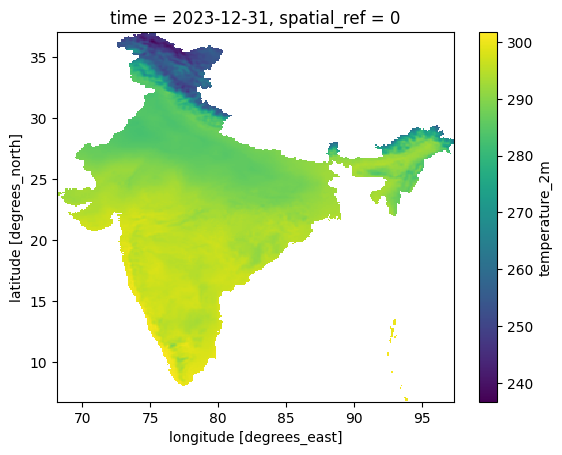

In [ ]:
# Plot a single timestep to verify the data
export_ds[variable].isel(time=-1).plot.imshow()

Save the results as a NetCDF file.

In [ ]:
%%time
output_file = f'era5_{variable}_india.nc'
output_path = os.path.join(output_folder, output_file)

# Enable compression
encoding = {variable: {'zlib': True}}
export_ds.to_netcdf(output_path, encoding=encoding)

CPU times: user 1h 5min 22s, sys: 1min 36s, total: 1h 6min 58s
Wall time: 1h 6min 23s


Once the data is exported, we read it with XArray and verify it looks fine and we are able to query the values to extract a time-series. Make sure to `chunk` the dataset so only the required chunks are loaded in RAM which improves performance a lot.

In [ ]:
local_ds = xr.open_dataset(output_path)
local_ds = local_ds.chunk({'x': 10, 'y': 10})
local_ds

<xarray.Dataset> Size: 5GB
Dimensions:         (time: 14610, x: 292, y: 303)
Coordinates:
  * time            (time) datetime64[ns] 117kB 1984-01-01 ... 2023-12-31
  * x               (x) float64 2kB 68.2 68.3 68.4 68.5 ... 97.0 97.1 97.2 97.3
  * y               (y) float64 2kB 37.04 36.94 36.84 ... 7.038 6.938 6.838
    spatial_ref     int64 8B ...
Data variables:
    temperature_2m  (y, x, time) float32 5GB dask.array<chunksize=(10, 10, 14610), meta=np.ndarray>
Attributes:
    crs:      EPSG:4326

In [ ]:
%%time
temperature = local_ds[variable]-273
time_series = temperature.interp(x=80.449, y=18.728)
df = time_series.to_series()
df.name = variable
df = df.reset_index()
df

CPU times: user 2.3 s, sys: 151 ms, total: 2.45 s
Wall time: 2.73 s


,time,temperature_2m
0,1984-01-01,22.302560
1,1984-01-02,21.521572
2,1984-01-03,20.157888
3,1984-01-04,21.262761
4,1984-01-05,22.494018
...,...,...
14605,2023-12-27,22.295943
14606,2023-12-28,22.856757
14607,2023-12-29,22.576667
14608,2023-12-30,22.472997


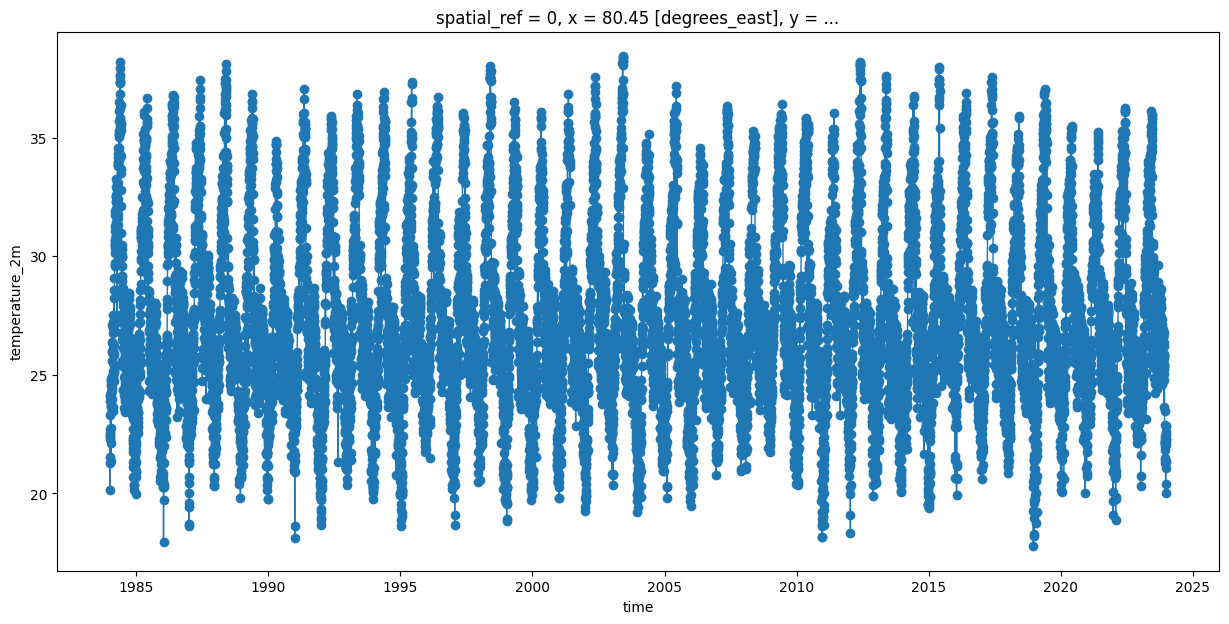

In [ ]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 1)

fig.set_size_inches(15, 7)
time_series.plot.line(ax=ax, x='time', marker='o', linestyle='-', linewidth=1)
plt.show()